In [130]:
import numpy as np
import pandas as pd
import scipy
from scipy import optimize
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

'''  
based on https://github.com/PaiViji/PythonFinance-PortfolioOptimization/blob/master/Lesson6_SharpeRatioOptimization/Lesson6_MainContent.ipynb
'''

'  \nbased on https://github.com/PaiViji/PythonFinance-PortfolioOptimization/blob/master/Lesson6_SharpeRatioOptimization/Lesson6_MainContent.ipynb\n'

In [131]:
# read in data 
data = pd.read_csv('case2data.csv', index_col = 0)
train, test = train_test_split(data, test_size = 0.2, shuffle = False)

In [132]:
def MaximizeSharpeRatioOptmzn(MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
    ''' 
    meanReturns = np.mean(arReturns, axis = 0) -> type = array
    covReturns = np.cov(arReturns, rowvar=False) -> type = matrix
    risk free rate = 0.03
    portfolio size = 6
    
    '''
    
    # define maximization of Sharpe Ratio using principle of duality
    def  f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
        
        #print("x: ", x)
        #print("coverance: ", CovarReturns)
        #print(x.shape)
        #print(MeanReturns.shape)
        funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
        funcNumer = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
        func = -(funcNumer / funcDenomr)
        return func

    #define equality constraint representing fully invested portfolio
    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    
    #define bounds and other parameters
    xinit=np.repeat(0.33, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = -1
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])
    
    #invoke minimize solver
    opt = optimize.minimize (f, x0 = xinit, args = (MeanReturns, CovarReturns,\
                             RiskFreeRate, PortfolioSize), method = 'SLSQP',  \
                             bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt
    

In [133]:
# function computes asset returns 
def StockReturnsComputing(StockPrice, Rows, Columns):
    
    import numpy as np
    
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):        # j: Assets
        for i in range(Rows-1):     # i: Daily Prices
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

    return StockReturn

In [134]:
# uniform weights
def calculateWeights(running_price_paths, running_weights_paths):
    portfolioSize = 6
    risk = 6
    meanReturns = np.mean(running_price_paths[-21:], axis = 0)
    #print("mean returns shape", meanReturns.shape)
    #print("first running prices", running_price_paths[-21:].T)
    covReturns = np.cov(running_price_paths[-21:].T)

    #compute daily risk free rate in percentage
    r0 = (np.power((1 + risk),  (1.0 / 360.0)) - 1.0) * 100 
    #print('\nRisk free rate (daily %): ', end="")
    #print ("{0:.3f}".format(r0)) 

    #initialization
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]
    maxSharpeRatio = 0

    #compute maximal Sharpe Ratio and optimal weights
    result = MaximizeSharpeRatioOptmzn(meanReturns, covReturns, r0, portfolioSize)
    xOptimal.append(result.x)

    
    #compute risk returns and max Sharpe Ratio of the optimal portfolio   
    xOptimalArray = np.array(xOptimal)
    Risk = np.matmul((np.matmul(xOptimalArray,covReturns)), np.transpose(xOptimalArray))
    expReturn = np.matmul(np.array(meanReturns),xOptimalArray.T)
    annRisk =   np.sqrt(Risk*251) 
    annRet = 251*np.array(expReturn) 
    maxSharpeRatio = (annRet-3)/annRisk 

    #set precision for printing results
    np.set_printoptions(precision=3, suppress = True)
    
    #print(result)
    #print(result.x)
    
    
    return result.x

In [157]:
## given grading scheme
class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.running_weights_paths = [[1/6, 1/6, 1/6, 1/6, 1/6, 1/6]]
        
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        ### edit: used np.append to make this work
        self.running_price_paths = np.append(self.running_price_paths, asset_prices)
    
        ### TODO Implement your code here
        #print(self.running_price_paths)
        
        historydays = 10
        
        paths1 = self.running_price_paths[-historydays * 6:].T
        pricePaths = []
        for i in range(historydays):
            sub = paths1[i*6: i*6+6]
            pricePaths.append(sub)
        pricePaths = np.array(pricePaths)
        #print(pricePaths)
        
            
        weights = calculateWeights(pricePaths, self.running_weights_paths)
        self.running_weights_paths.append(weights)
        
        return weights
    
    
def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

[-0.071  0.818  0.062  0.196 -0.015  0.01 ]
[-0.054  0.79   0.062  0.17   0.038 -0.006]
[ 0.132  0.397 -0.009  0.103  0.309  0.068]
[0.106 0.465 0.021 0.006 0.192 0.21 ]
[0.117 0.46  0.043 0.003 0.277 0.1  ]
[ 0.091  0.428  0.138 -0.139  0.221  0.262]
[ 0.146  0.098  0.152 -0.082  0.445  0.241]
[ 0.17   0.089  0.156 -0.114  0.4    0.299]
[ 0.121  0.768 -0.021  0.02   0.021  0.092]
[ 0.113  0.691 -0.018  0.081  0.015  0.118]
[ 0.039  0.812 -0.027  0.177 -0.056  0.057]
[-0.003  0.896 -0.045  0.208 -0.073  0.018]
[-0.016  0.856 -0.035  0.25  -0.097  0.042]
[-0.081  0.78  -0.035  0.384 -0.455  0.408]
[-0.044  1.    -0.053  0.31  -0.372  0.158]
[-0.041  1.    -0.06   0.32  -0.403  0.183]
[-0.127  1.     0.06   0.465 -0.996  0.598]
[-0.034  1.     0.049  0.265 -0.543  0.263]
[ 0.103  1.     0.072 -0.008 -0.277  0.11 ]
[ 0.459  0.519  0.066 -0.733  1.    -0.31 ]
[ 0.309  0.615  0.018 -0.502  0.966 -0.407]
[ 0.088  0.76   0.011  0.068  0.179 -0.106]
[ 0.175  0.29   0.046  0.09   0.449 -0.05 ]


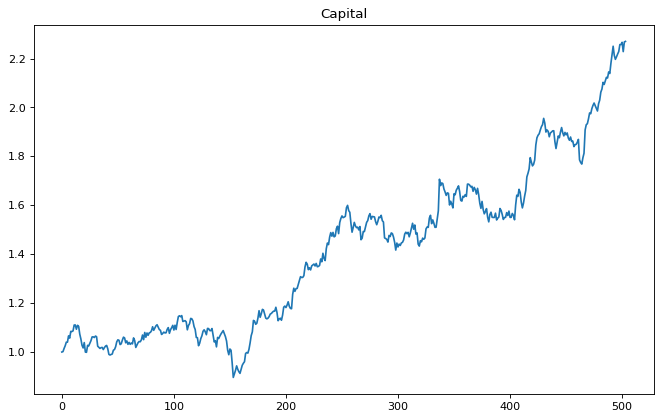

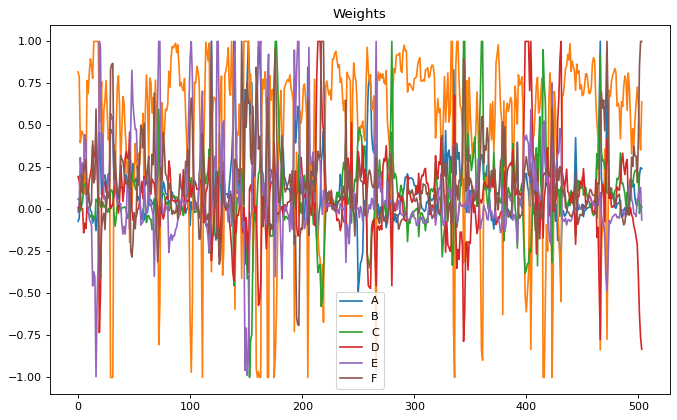

In [158]:
# run simulation
sharpe, capital, weights = grading(train, test)
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(test)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(test)), weights)
plt.legend(test.columns)
plt.show()